In [15]:
# author: Tom Stone <tomstone@stanford.edu>
# author: Proloy Das <email:proloyd94@gmail.com>
# License: BSD (3-clause)
%matplotlib widget
import numpy as np

from matplotlib import pyplot
from utils import *    # Familiar line? Now you are statring to appereciate this, right? :)


pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "figure.constrained_layout.use": True,
    "savefig.dpi": 300
})

notebook: Knock, knock!

you: Who is there?

notebook: Your familar line of code.

In [16]:
rng = np.random.default_rng(2345)

## Generating an AR(4) signal

For this example, we begin with generating 1024 samples of the following AR(4) process:
$$\begin{aligned}
x_k = 3.28285739 x_{k-1} - 4.61269743 x_{k-2} + 3.21388527 x_{k-3} - 0.95865639 x_{k-4} + w_k; \ \ w_k \sim \mathcal{N}(0, 1)
\end{aligned}$$
We will start with $x_0=0, x_1=0, x_2=0$, and $x_3=0$, generate 1024 + 50 samples, and discard first 50 samples.
Also we will create the time indices corresponding the white noise sequence.

In [17]:
phi = np.array([1., -3.28285739, 4.61269743, -3.21388527, 0.95865639])  
# Note that we need to reverse the sign of AR coeffiences, when they are given in this form.
n = 1024
# Generate the samples of driving noise.
w = rng.normal(size=n+50)
# Generate the AR process samples starting from k = 4.
x = np.zeros(n + 50)
for i in range(4, n+50):
    x[i] = - phi[1] * x[i-1] - phi[2] * x[i-2] - phi[3] * x[i-3] - phi[4] * x[i-4] + w[i]
    # x[i] = - np.inner(phi[1:], x[i-phi.shape[-1]+1:i][::-1]) + w[i]
ar4 = x[50:]

# The time indices associated with the samples.
time_indices = np.arange(1024)

Plot the white noise againt time using matplotlib.

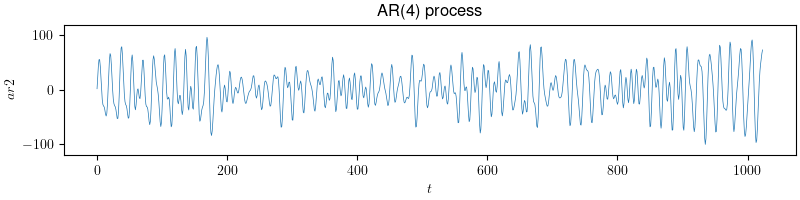

In [18]:
fig1, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(time_indices, ar4, linewidth=0.5)
ax.set_xlabel('$t$')
ax.set_ylabel('$ar2$')
ax.set_ylim([-120, 120])
_ = ax.set_title('AR(4) process')

Now we compute the autocovaraince sequence from the realization that we generated.

In [19]:
# Sampe autocorrelation
max_lag = ar4.shape[-1] - 1
sample_acov, lags = compute_autocovaraince(ar4, max_lag)

The following lines of code generates the true autocovariance sequence from the AR(4) process definition.

In [20]:
true_acov, lags_ = compute_theoritical_ar_acov(phi, max_lag)

Lets take a quick look at the autocovarainces to gauze the estimation error, i.e., the noise.

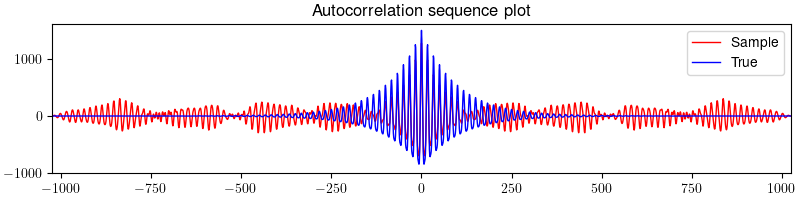

In [21]:
fig1, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(lags, sample_acov, linewidth=1, color='r', label='Sample')
ax.plot(lags_, true_acov, linewidth=1, color='b', label='True')
ax.set_ylim([-1000.0, 1600])
ax.legend()
ax.set_xlim([-1024, 1024])
_ = ax.set_title('Autocorrelation sequence plot')

Now we are ready for periodograms! 

Small note: we will make small changes in the computation of the true spectrum. The AR(4) process is so `complicated` that even covaraince upto 1023 lags are not sufficient to get the true spectrum. We will use our falimiar `signal.freqz` function to compute the spectrum in this case. Compare the first two lines to the third line in the fiollowing code block.

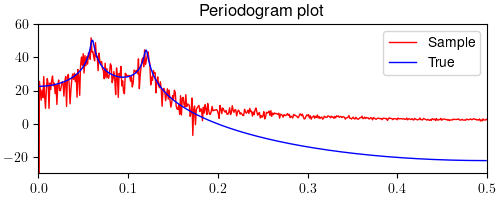

In [22]:
# # True spectrum from first 1023 autocovariance values
# S_xx_true = np.abs(fft.fft(true_acov))
# freqs_ = np.linspace(0, 1, num=len(lags))

# True spectrum using frequency response function
freqs_, freq_respone = signal.freqz(1, phi, fs=1)
S_xx_true = np.abs(freq_respone) ** 2

S_xx_est, freqs = compute_periodogram(ar4)


# Periodogram plot
fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(S_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 60])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Periodogram plot')

Bias!

How do we take care of that?
Tapering!
Let's now go back to `white_noise.ipynb`.  We will develop the tapering there, and revisit other notebooks.

# Bias Reduction

Welcome! Now you are well equipped with the `compute_tapered_periodogram()` function. Lets verify if the bias improves.

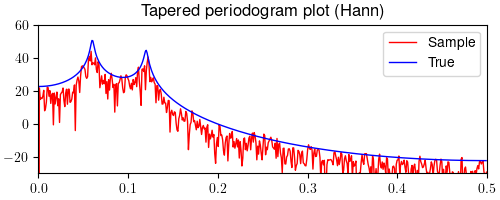

In [23]:
St_xx_est, freqs = compute_tapered_periodogram(ar4, 'hann')

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 60])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot (Hann)')

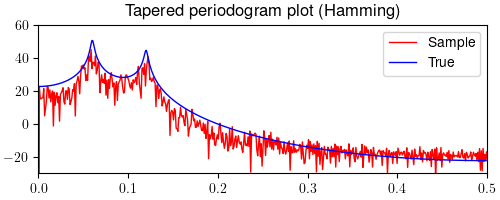

In [24]:
St_xx_est, freqs = compute_tapered_periodogram(ar4, 'hamming')

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 60])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot (Hamming)')

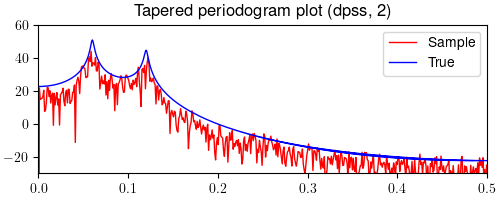

In [25]:
NW = 2
St_xx_est, freqs = compute_tapered_periodogram(ar4, ('dpss', NW))

S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 60])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title(f'Tapered periodogram plot (dpss, {NW})')

Good job, guys! Now it's time to dip our toes into the variance reduction territory. 

Multitaper spectram is coming! 

Lets fall back to `white_noise.ipynb`, develop our function, and come back here.

# Variance Reduction
We will import the `compute_multitaper_spectrogram()` function that you implemented.

NOTE: you will need to restart the kernel, and rerun the notebook from the begining for this notebook to see the `compute_multitaper_spectrogram()` function in the `utils.py` script.

Once imported, compute the multitaper spectrum and compare it to the true spectrum.

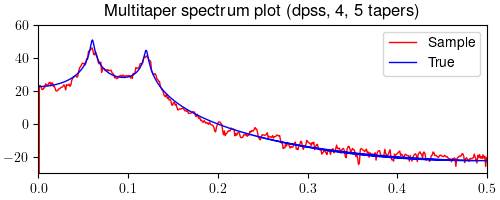

In [26]:
NW = 4
Kmax = 5
Smtm_xx_est, freqs = compute_multitaper_spectrum(ar4, NW=NW, Kmax=Kmax)

S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(Smtm_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 60])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title(f'Multitaper spectrum plot (dpss, {NW}, {Kmax} tapers)')

Q1. Try varying `K_max` and see what happens! 